In [1]:
import requests as rq
import numpy as np
from scipy.io import wavfile
from scipy.fft import fft
from scipy.signal import butter, sosfilt
from tabulate import tabulate
import IPython.display as ipd
import io

# Duração do áudio sintetizado (em segundos)
DURATION = 20.0

# # Buscando o áudio no GitHub
# AUDIO_URL = 'https://github.com/RexynyN/current-semester/raw/main/CS/runaway.wav'
# resposta = rq.get(AUDIO_URL) 
# rate, audio = wavfile.read(io.BytesIO(resposta.content))    

# Se for local
AUDIO_PATH = "runaway.wav"
rate, audio = wavfile.read(AUDIO_PATH)


In [2]:
# Normaliza o áudio entre -1 <= x <= 1
def normalize(x):
    x = x / np.abs(x).max() 
    mask = (x > 1)
    x[mask] = 1
    mask = (x < -1)
    x[mask] = -1
    return x 

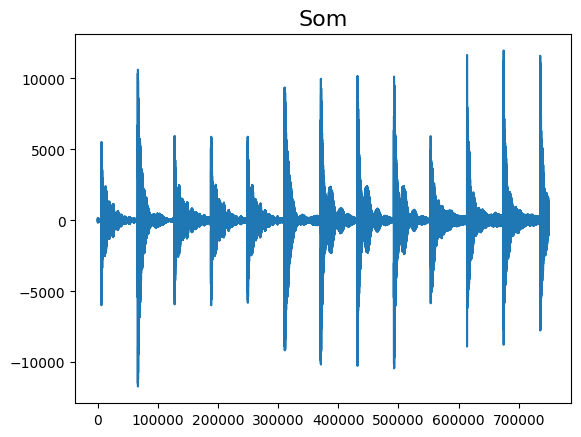

In [3]:
# Plot the audio signal in time
import matplotlib.pyplot as plt
plt.plot(audio)
plt.title('Som',size=16);

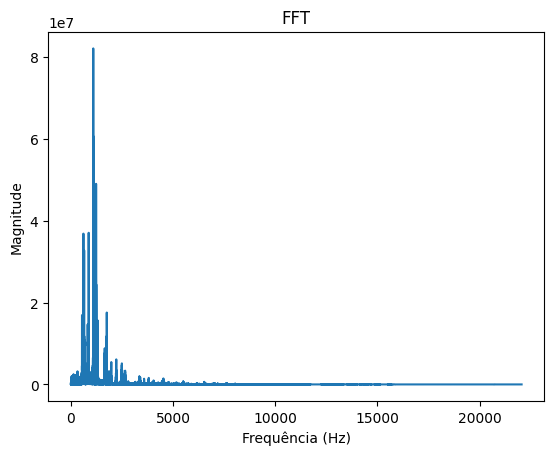

In [4]:
# Calcula o fft e as frequências
N = len(audio)
fft_result = fft(audio)
fft_result = np.abs(fft_result[:N//2])
freqs = np.fft.fftfreq(N, 1/rate)[:N//2]

# Cria o gráfico do espectro
plt.plot(freqs, fft_result)
plt.title('FFT')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.show();

In [5]:
def top_5_frequencies(data, sample_rate):
    # Realiza a Tranformada de Fourier (FFT) e calcula as frequências correspondentes
    N = len(data)
    fft_result = fft(data)
    freqs = np.fft.fftfreq(N, 1/sample_rate)
    
    # Considera apenas a metade positiva do espectro de frequência
    positive_freqs = freqs[:N//2]
    positive_magnitudes = np.abs(fft_result[:N//2])
    
    # Converte as magnitudes para decibéis
    positive_magnitudes_db = 20 * np.log10(positive_magnitudes)
    
    # Retorna as 5 frequências mais presentes e suas magnitudes em dB
    top_indices = np.argsort(positive_magnitudes_db)[-5:][::-1]
    top_frequencies = positive_freqs[top_indices]
    top_magnitudes_db = positive_magnitudes_db[top_indices]
    
    return top_frequencies, top_magnitudes_db

# Pega as 5 frequencias mais intensas
frequencies, magnitudes_db = top_5_frequencies(audio, rate)
table = []
for idx, (freq, mag_db) in enumerate(zip(frequencies, magnitudes_db)):
    table.append([idx+1, f"{freq:.2f} Hz", f"{mag_db:.2f} dB"])

print("Frequências mais intensas:\n")
print(
    tabulate(
        table,
        headers=["Top", "Frequência (Hz)", "Magnitude (dB)"],
    )
)

Frequências mais intensas:

  Top  Frequência (Hz)    Magnitude (dB)
-----  -----------------  ----------------
    1  1103.47 Hz         158.28 dB
    2  1103.53 Hz         158.23 dB
    3  1103.41 Hz         156.85 dB
    4  1103.59 Hz         156.39 dB
    5  1104.24 Hz         156.17 dB


In [6]:
# Função auxiliar para pegar a faixa de preservação de frequências
def get_cuts(freqs):
    return min(freqs), max(freqs)


# Cria um filtro Butterworth de passa-baixo
def bandpass_filter(data, sample_rate, lowcut, highcut):
    nyq = 0.5 * sample_rate
    low = lowcut / nyq
    high = highcut / nyq

    # Passa o filtro butterworth
    sos = butter(5, [low, high], analog=False, btype='band', output='sos')
    y = sosfilt(sos, data)
    return y.astype(np.int16)

# Pega a faixa de frequências que vamos preservar
lowcut, highcut = get_cuts(frequencies)

# Aplica o filtro passa-baixo na faixa decidida e salva o áudio
filtered_data = bandpass_filter(audio, rate, lowcut, highcut)

# Salvar se local
# clean_filename = AUDIO_PATH.split(".")[0]
# wavfile.write(f'{clean_filename}-filtered.wav', rate, filtered_data)

print(f"Faixa de frequência filtrada: {lowcut:.2f} Hz - {highcut:.2f} Hz")

Faixa de frequência filtrada: 1103.41 Hz - 1104.24 Hz


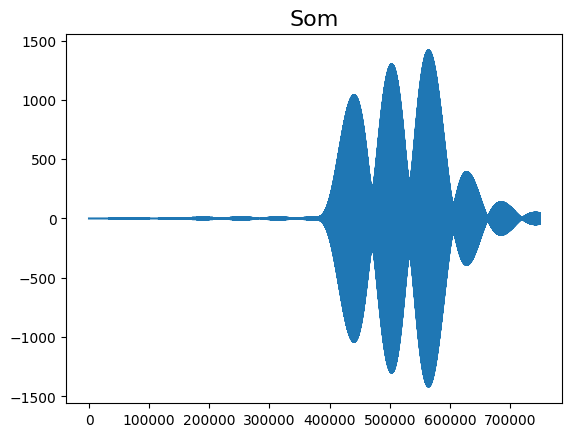

In [7]:
# Plota o som filtrado
plt.plot(filtered_data)
plt.title('Som',size=16);

## Áudio Original

In [8]:
ipd.Audio(normalize(audio).T, rate=rate, autoplay=False) 

## Áudio Filtrado

In [9]:
ipd.Audio(filtered_data, rate=rate, autoplay=False) 

## Síntese

In [10]:
# Pega o top 5 frequências e magnitudes relativas
def top_5_frequencies_relative(data, sample_rate):
    # Realiza a Transformada Rápida de Fourier (FFT)
    N = len(data)
    fft_result = np.fft.fft(data)
    
    # Calcula a frequência correspondente para cada ponto da FFT
    freqs = np.fft.fftfreq(N, 1/sample_rate)
    positive_freqs = freqs[:N//2]
    positive_magnitudes = np.abs(fft_result[:N//2])
    
    # Encontra as 5 frequências mais presentes e suas magnitudes
    top_indices = np.argsort(positive_magnitudes)[-5:][::-1]
    top_frequencies = positive_freqs[top_indices]
    top_magnitudes = positive_magnitudes[top_indices]
    
    # Calcula as magnitudes relativas em decibéis
    max_magnitude = top_magnitudes[0]
    relative_magnitudes_db = 20 * np.log10(top_magnitudes / max_magnitude)
    
    return top_frequencies, relative_magnitudes_db

# Faz a síntese aditiva
def additive_synthesis(frequencies, amplitudes_db, sample_rate, duration=1.0):
    # Cria um array inicializado com a duração do áudio que queremos sintetizar
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    signal = np.zeros_like(t)
    
    # Converte as amplitudes de dB para linear
    amplitudes = 10**(amplitudes_db / 20)
    
    # Sintetiza o áudio usando as frequências e amplitudes que foram passadas
    # Usando a equação fundamental
    for freq, amp in zip(frequencies, amplitudes):
        signal += amp * np.sin(2 * np.pi * freq * t)
    
    # Normaliza o sinal
    signal = signal / np.max(np.abs(signal))
    return signal

# Pega as frequências relativas e a duração do áudio sintetizado
frequencies, relative_magnitudes_db = top_5_frequencies_relative(audio, rate)

# Gera o áudio
synthesized_signal = additive_synthesis(frequencies, relative_magnitudes_db, rate, DURATION)

table = []
for idx, (freq, mag_db) in enumerate(zip(frequencies, relative_magnitudes_db)):
    table.append([idx+1, f"{freq:.2f} Hz", f"{mag_db:.2f} dB"])

print(
    tabulate(
        table,
        headers=["Top", "Frequência (Hz)", "Amplitude Relativa (dB)"],
    )
)

# Para caso seja local
clean_filename = AUDIO_PATH.split(".")[0]
wavfile.write(f'{clean_filename}-synthesized.wav', rate, (synthesized_signal * 32767).astype(np.int16))

  Top  Frequência (Hz)    Amplitude Relativa (dB)
-----  -----------------  -------------------------
    1  1103.47 Hz         0.00 dB
    2  1103.53 Hz         -0.05 dB
    3  1103.41 Hz         -1.43 dB
    4  1103.59 Hz         -1.89 dB
    5  1104.24 Hz         -2.11 dB


## Áudio Sintetizado

In [11]:
ipd.Audio(synthesized_signal, rate=rate, autoplay=False)

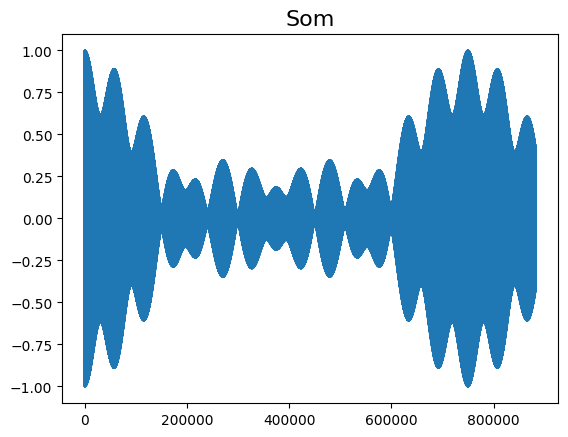

In [12]:
# Plota o som sintetizado
plt.plot(synthesized_signal)
plt.title('Som',size=16);